In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import simweights
import pickle
import os, sys
import re
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [4]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [6]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets

# set the inputs
reco_versions = ["evtgen_v4_rec_v9", "spice_tau_reco"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [7]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [8]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/compare_spice_ftp/purity_efficiency_plots"
os.system(f"mkdir -p {plotting_path}")

0

In [9]:
# weight functions
spline_file = '/data/ana/Diffuse/NNMFit/MCEq_splines/v1.2.1/MCEq_splines_PRI-Gaisser-H4a_INT-SIBYLL23c_allfluxes.pickle'

# conventional            
flux_keys_conv =  ['conv_antinumu','conv_numu','conv_antinue','conv_nue','conv_antinutau','conv_nutau']
spline_object_conv = SplineHandler(spline_file, flux_keys_conv)
conv_flux = spline_object_conv.return_weight
generator_conv = lambda pdgid, energy, cos_zen: conv_flux(pdgid, energy, cos_zen)

# prompt
flux_keys_pr =  ['pr_antinumu','pr_numu','pr_antinue','pr_nue','pr_antinutau','pr_nutau']
spline_object_pr = SplineHandler(spline_file, flux_keys_pr)
pr_flux = spline_object_pr.return_weight
generator_pr = lambda pdgid, energy, cos_zen: pr_flux(pdgid, energy, cos_zen)

# astro
gamma_astro = 2.87
per_flavor_norm = 2.12
def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [10]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    # calculate weights
    for key in simulation_dataset:
        simulation_dataset[key]['weights_astro'] = simulation_dataset[key]["weighter"].get_weights(AstroFluxModel) * livetime_s
        simulation_dataset[key]['weights_conv'] = simulation_dataset[key]["weighter"].get_weights(generator_conv) * livetime_s
        simulation_dataset[key]['weights_pr'] = simulation_dataset[key]["weighter"].get_weights(generator_pr) * livetime_s


    return simulation_dataset



In [11]:
keys_to_merge = {}

keys_to_merge["evtgen_v4_rec_v9"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["spice_tau_reco"] = {
    "NuE" : ["NuE_midE1", "NuE_highE1", "NuE_midE2", "NuE_highE2"],
    "NuMu" : ["NuMu_midE1", "NuMu_highE1","NuMu_midE2", "NuMu_highE2"],
    "NuTau" : ["NuTau_midE1", "NuTau_highE1","NuTau_midE2", "NuTau_highE2"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],

}

In [12]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau
----- Extracting files for NuTau_midE1
----- Extracting files for NuTau_highE1
----- Extracting files for NuTau_midE2
----- Extracting files for NuTau_highE2
----- Extracting files for NuE_midE1
----- Extracting files for NuE_highE1
----- Extracting files for NuE_midE2
----- Extracting files for NuE_highE2
----- Extracting files for NuMu_midE1
----- Extracting files for NuMu_highE1
----- Extracting files for NuMu_midE2
----- Extracting files for NuMu_highE2
----- Creating new key NuE
Using NuE_midE1
Using NuE_highE1
Using Nu

In [13]:
dataset_label_dict = {
    "evtgen_v4_rec_v9" : "ftp-v3",
    "spice_tau_reco" : "spice v3.2.1",
}

check if merging works now, seems to be fine

In [14]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    for flavor in ['NuE', "NuMu", "NuTau"]:
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    ConventionalAtmosphericPassingFractions = simulation_dataset[flavor]["weighter"].get_column("ConventionalAtmosphericPassingFractions", "value")
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s * ConventionalAtmosphericPassingFractions
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.2f} ± {err_conv:.2f}"

    # Prompt
    PromptAtmosphericPassingFractions = simulation_dataset[flavor]["weighter"].get_column("PromptAtmosphericPassingFractions", "value")
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s * PromptAtmosphericPassingFractions
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[ dataset_label_dict[key] ] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuE', 'NuMu', 'NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

                 astro_NuE    astro_NuMu   astro_NuTau          conv       prompt
ftp-v3        56.92 ± 0.55  20.60 ± 0.25  35.03 ± 0.40  25.68 ± 0.99  7.07 ± 0.09
spice v3.2.1  56.77 ± 0.56  20.42 ± 0.22  34.89 ± 0.43  23.04 ± 0.80  6.93 ± 0.09


In [16]:
flavors = ['NuTau', 'NuE', 'NuMu']

channels = {
    1 : "Single Cascade",
    2 : "Double cascade",
    3 : "Track",
}

classification_vars = ["FinalTopology", "FinalEventClass"]

MCInteractionEventclass_names = ['TrueDouble','TrueCascade', 'TrueTrack']


Lets check the efficiency and purity of the selections

/tmp/ipykernel_18314/4106171744.py:51: RuntimeWarning: invalid value encountered in divide
  purity = {comp: hists[comp] / hists["total"] for comp in hists if comp != "total"}
/tmp/ipykernel_18314/4106171744.py:52: RuntimeWarning: invalid value encountered in divide
  efficiency = {comp: hists[comp] / hists_total[comp] for comp in hists if comp != "total"}


-------------------- channel 2 classification_var FinalTopology energy_cut_threshold None
NuTau 2.9590997278540887
NuE 1.1460781358827243
NuMu 0.3513784319094064
conv 0.42356520954899995
prompt 0.1527727400953377
total 5.032894245290558
----------
NuTau 34.89374351021246
NuE 56.771607506826754
NuMu 20.423258952378536
conv 23.039110080031932
prompt 6.928670957804474
total 142.05639100725415


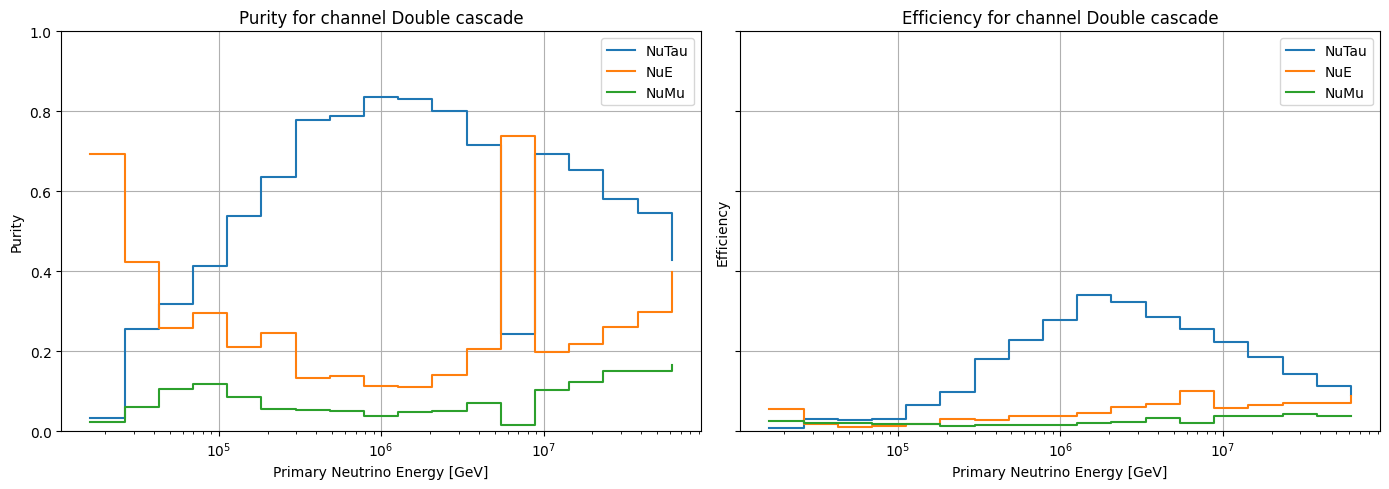

In [17]:
def purity_efficiency_flavor_plot(simulation_dataset_name, channel, classification_var="FinalTopology", energy_cut_threshold=None):

    simulation_dataset = simulation_datasets[simulation_dataset_name]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    bins = np.geomspace(1e4, 1e8, 20)

    hists = {}
    hists_total = {}

    # Loop over flavors
    for flavor in flavors:
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
        classification = simulation_dataset[flavor]["weighter"].get_column(classification_var, "value")
        PrimaryNeutrinoEnergy = simulation_dataset[flavor]["weighter"].get_column("I3MCWeightDict", "PrimaryNeutrinoEnergy")
        RecoETot = simulation_dataset[flavor]["weighter"].get_column("RecoETot", "value")
        
        mask = np.ones_like(RecoETot, dtype=bool)
        if energy_cut_threshold:
            mask &= RecoETot > energy_cut_threshold
        
        hists_total[flavor], _ = np.histogram(PrimaryNeutrinoEnergy[mask], weights=weights[mask], bins=bins)
        hists[flavor], _ = np.histogram(PrimaryNeutrinoEnergy[mask & (classification == channel)], weights=weights[mask & (classification == channel)], bins=bins)

    # Conventional + Prompt (NuAll)
    flavor_all = "NuAll"
    classification = simulation_dataset[flavor_all]["weighter"].get_column(classification_var, "value")
    ConventionalAtmosphericPassingFractions = simulation_dataset[flavor_all]["weighter"].get_column("ConventionalAtmosphericPassingFractions", "value")
    PromptAtmosphericPassingFractions = simulation_dataset[flavor_all]["weighter"].get_column("PromptAtmosphericPassingFractions", "value")
    RecoETot = simulation_dataset[flavor_all]["weighter"].get_column("RecoETot", "value")
    PrimaryNeutrinoEnergy = simulation_dataset[flavor_all]["weighter"].get_column("I3MCWeightDict", "PrimaryNeutrinoEnergy")

    mask = np.ones_like(RecoETot, dtype=bool)
    if energy_cut_threshold:
        mask &= RecoETot > energy_cut_threshold

    weights_conv = simulation_dataset[flavor_all]["weighter"].get_weights(generator_conv) * livetime_s * ConventionalAtmosphericPassingFractions
    weights_prompt = simulation_dataset[flavor_all]["weighter"].get_weights(generator_pr) * livetime_s * PromptAtmosphericPassingFractions

    hists_total["conv"], _ = np.histogram(PrimaryNeutrinoEnergy[mask], weights=weights_conv[mask], bins=bins)
    hists_total["prompt"], _ = np.histogram(PrimaryNeutrinoEnergy[mask], weights=weights_prompt[mask], bins=bins)

    hists["conv"], _ = np.histogram(PrimaryNeutrinoEnergy[mask & (classification == channel)], weights=weights_conv[mask & (classification == channel)], bins=bins)
    hists["prompt"], _ = np.histogram(PrimaryNeutrinoEnergy[mask & (classification == channel)], weights=weights_prompt[mask & (classification == channel)], bins=bins)

    # total histograms for denominator
    hists_total["total"] = sum(hists_total.values())
    hists["total"] = sum(hists.values())

    # Calculate purity and efficiency
    purity = {comp: hists[comp] / hists["total"] for comp in hists if comp != "total"}
    efficiency = {comp: hists[comp] / hists_total[comp] for comp in hists if comp != "total"}

    # Purity plot
    for flavor in flavors:
        ax1.step(bins[:-1], purity[flavor], where='post', label=flavor)
    ax1.set_xscale('log')
    ax1.set_ylabel('Purity')
    ax1.set_xlabel('Primary Neutrino Energy [GeV]')
    ax1.set_title(f'Purity for channel {channels[channel]}')
    ax1.legend()
    ax1.set_ylim(0, 1)  # <-- Fix y-axis
    ax1.grid(True)

    # Efficiency plot
    for flavor in flavors:
        ax2.step(bins[:-1], efficiency[flavor], where='post', label=flavor)
    ax2.set_xscale('log')
    ax2.set_ylabel('Efficiency')
    ax2.set_xlabel('Primary Neutrino Energy [GeV]')
    ax2.set_title(f'Efficiency for channel {channels[channel]}')
    ax2.legend()
    ax2.set_ylim(0, 1)  # <-- Fix y-axis
    ax2.grid(True)

    plt.tight_layout()
    # plt.savefig(f"{plotting_path}/purity_efficiency_flavor_{simulation_dataset_name}_classification-{classification_var}_channel-{channel}_energycut-{energy_cut_threshold}.pdf")

    print(20*"-", "channel", channel, "classification_var", classification_var, "energy_cut_threshold",energy_cut_threshold)
    for comp in hists:
        print(comp, sum(hists[comp]))
    print(10*"-")
    for comp in hists:
        print(comp, sum(hists_total[comp]))

    plt.show()




# for simulation_dataset_name in simulation_datasets:
#     for channel in channels:
#         for classification_var in classification_vars:
#             for energy_cut_threshold in [None, 60e3]:
#                 purity_efficiency_flavor_plot( simulation_dataset_name=simulation_dataset_name, channel=channel, classification_var=classification_var, energy_cut_threshold= energy_cut_threshold )

purity_efficiency_flavor_plot( "spice_tau_reco", 2, "FinalTopology", None )
# purity_efficiency_flavor_plot( "spice_tau_reco", 2, "FinalEventClass", None )


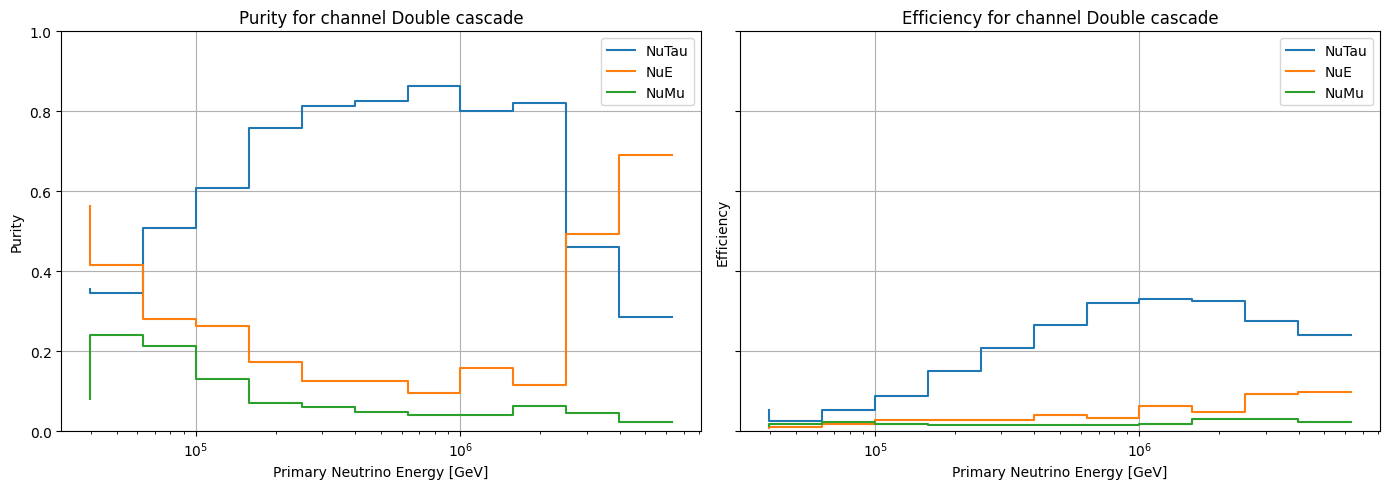

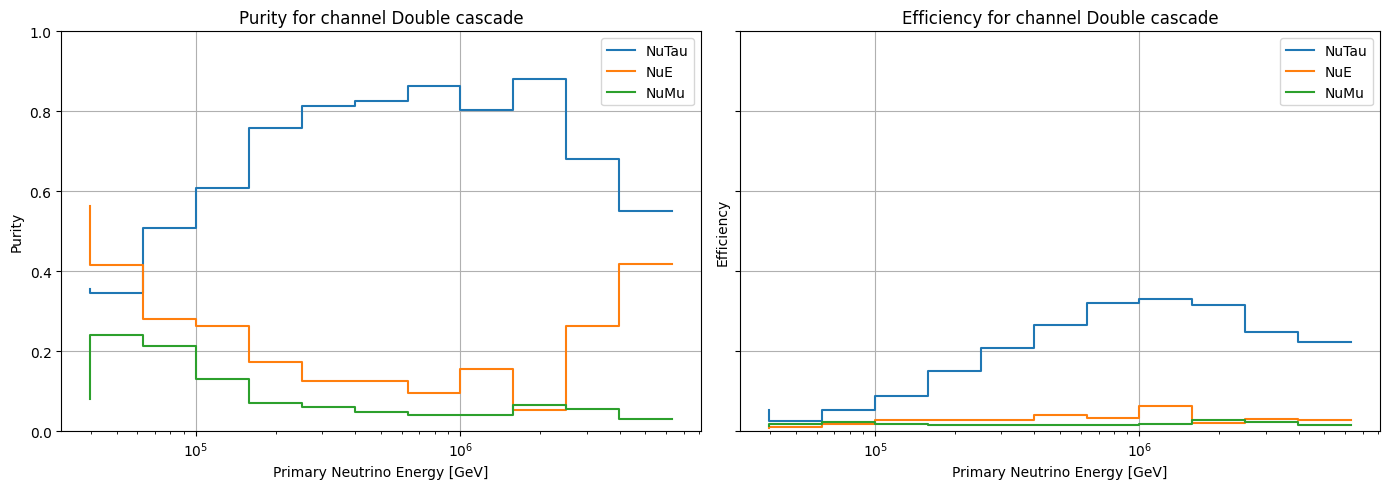

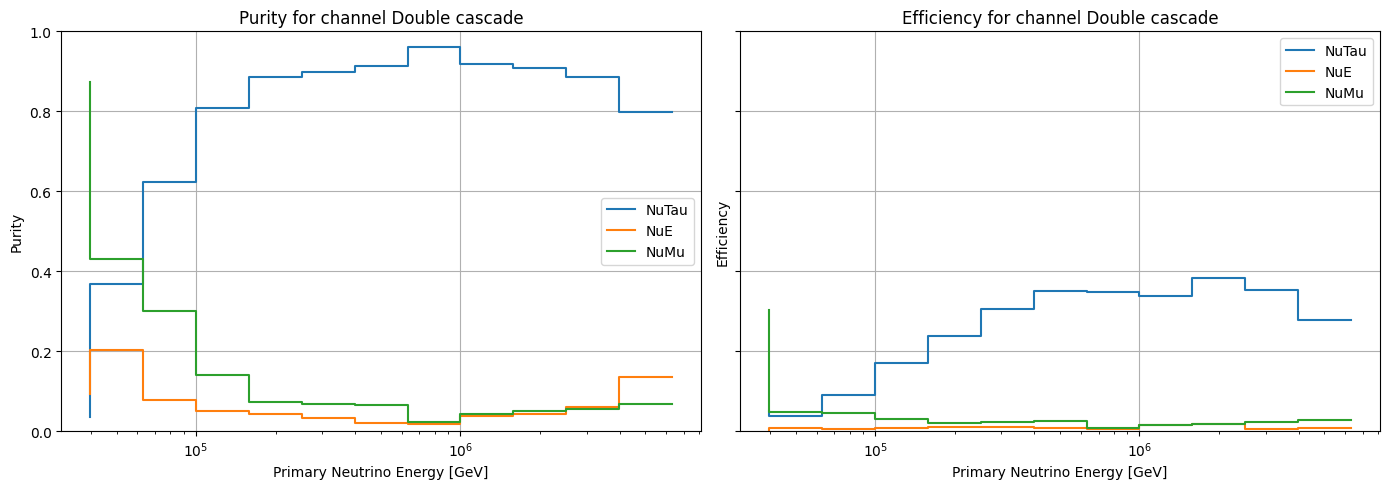

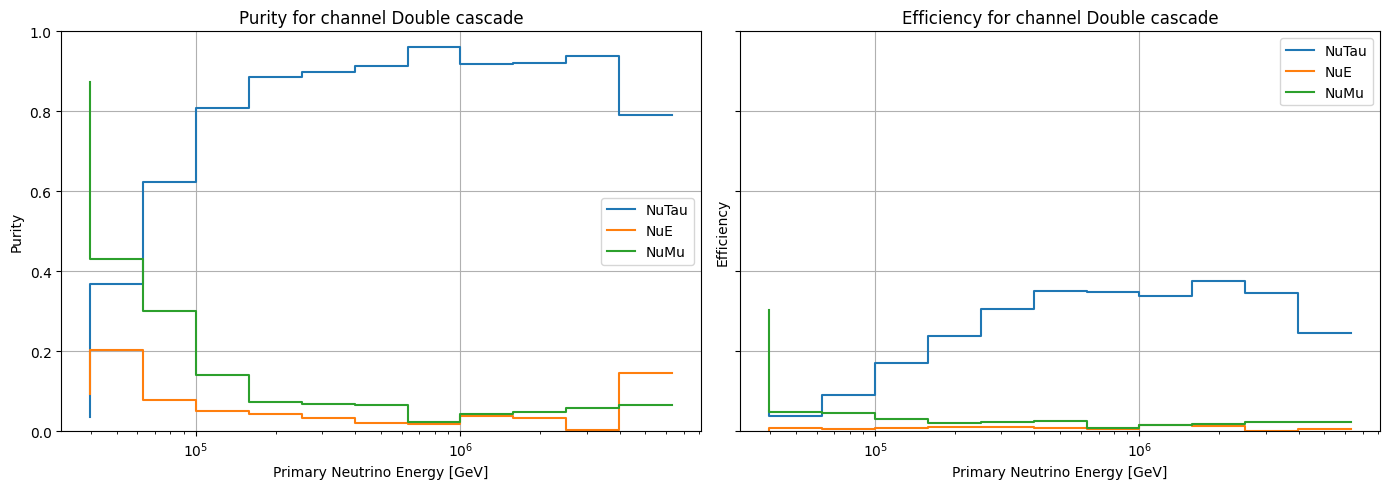

In [21]:
def purity_efficiency_flavor_neha_plot(simulation_dataset_name, channel, classification_var="FinalTopology", energy_cut_threshold=60e3):

    simulation_dataset = simulation_datasets[simulation_dataset_name]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    bins = np.logspace(4.6,7,13)

    hists = {}
    hists_total = {}

    # Loop over flavors
    for flavor in flavors:
        ConventionalAtmosphericPassingFractions = simulation_dataset[flavor]["weighter"].get_column("ConventionalAtmosphericPassingFractions", "value")
        PromptAtmosphericPassingFractions = simulation_dataset[flavor]["weighter"].get_column("PromptAtmosphericPassingFractions", "value")
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s + \
                  simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s * ConventionalAtmosphericPassingFractions + \
                  simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s * PromptAtmosphericPassingFractions
        classification = simulation_dataset[flavor]["weighter"].get_column(classification_var, "value")
        PrimaryNeutrinoEnergy = simulation_dataset[flavor]["weighter"].get_column("I3MCWeightDict", "PrimaryNeutrinoEnergy")
        RecoETot = simulation_dataset[flavor]["weighter"].get_column("RecoETot", "value")
        
        mask = np.ones_like(RecoETot, dtype=bool)
        if energy_cut_threshold:
            mask &= RecoETot > energy_cut_threshold
        
        hists_total[flavor], _ = np.histogram(PrimaryNeutrinoEnergy[mask], weights=weights[mask], bins=bins)
        hists[flavor], _ = np.histogram(PrimaryNeutrinoEnergy[mask & (classification == channel)], weights=weights[mask & (classification == channel)], bins=bins)

    # total histograms for denominator
    hists_total["total"] = sum(hists_total.values())
    hists["total"] = sum(hists.values())

    # Calculate purity and efficiency
    purity = {comp: hists[comp] / hists["total"] for comp in hists if comp != "total"}
    efficiency = {comp: hists[comp] / hists_total[comp] for comp in hists if comp != "total"}

    # Purity plot
    for flavor in flavors:
        ax1.step(bins[:-1], purity[flavor], label=flavor)
    ax1.set_xscale('log')
    ax1.set_ylabel('Purity')
    ax1.set_xlabel('Primary Neutrino Energy [GeV]')
    ax1.set_title(f'Purity for channel {channels[channel]}')
    ax1.legend()
    ax1.set_ylim(0, 1)  # <-- Fix y-axis
    ax1.grid(True)

    # Efficiency plot
    for flavor in flavors:
        ax2.step(bins[:-1], efficiency[flavor], label=flavor)
    ax2.set_xscale('log')
    ax2.set_ylabel('Efficiency')
    ax2.set_xlabel('Primary Neutrino Energy [GeV]')
    ax2.set_title(f'Efficiency for channel {channels[channel]}')
    ax2.legend()
    ax2.set_ylim(0, 1)  # <-- Fix y-axis
    ax2.grid(True)

    plt.tight_layout()

    plt.savefig(f"{plotting_path}/purity_efficiency_flavor_neha_{simulation_dataset_name}_classification-{classification_var}_channel-{channel}_energycut-{energy_cut_threshold}.pdf")

    plt.show()

purity_efficiency_flavor_neha_plot( "spice_tau_reco", 2, "FinalTopology", 60e3 )
purity_efficiency_flavor_neha_plot( "spice_tau_reco", 2, "FinalEventClass", 60e3 )
purity_efficiency_flavor_neha_plot( "evtgen_v4_rec_v9", 2, "FinalTopology", 60e3 ) 
purity_efficiency_flavor_neha_plot( "evtgen_v4_rec_v9", 2, "FinalEventClass", 60e3 )



/tmp/ipykernel_17213/2850094792.py:55: RuntimeWarning: invalid value encountered in divide
  purity = {comp: hists[comp] / hists["total"] for comp in hists if comp != "total"}
/tmp/ipykernel_17213/2850094792.py:56: RuntimeWarning: invalid value encountered in divide
  efficiency = {comp: hists[comp] / hists_total[comp] for comp in hists if comp != "total"}


-------------------- channel 2 classification_var FinalTopology energy_cut_threshold None
TrueCascade 1.3452014455763266
TrueDouble 2.8138416428189847
TrueTrack 0.2975132072509061
conv 0.42356520954899995
prompt 0.1527727400953377
total 5.032894245290556
----------
TrueCascade 65.58266764358024
TrueDouble 27.549246045172048
TrueTrack 18.95669628066582
conv 23.039110080031932
prompt 6.928670957804474
total 142.05639100725452


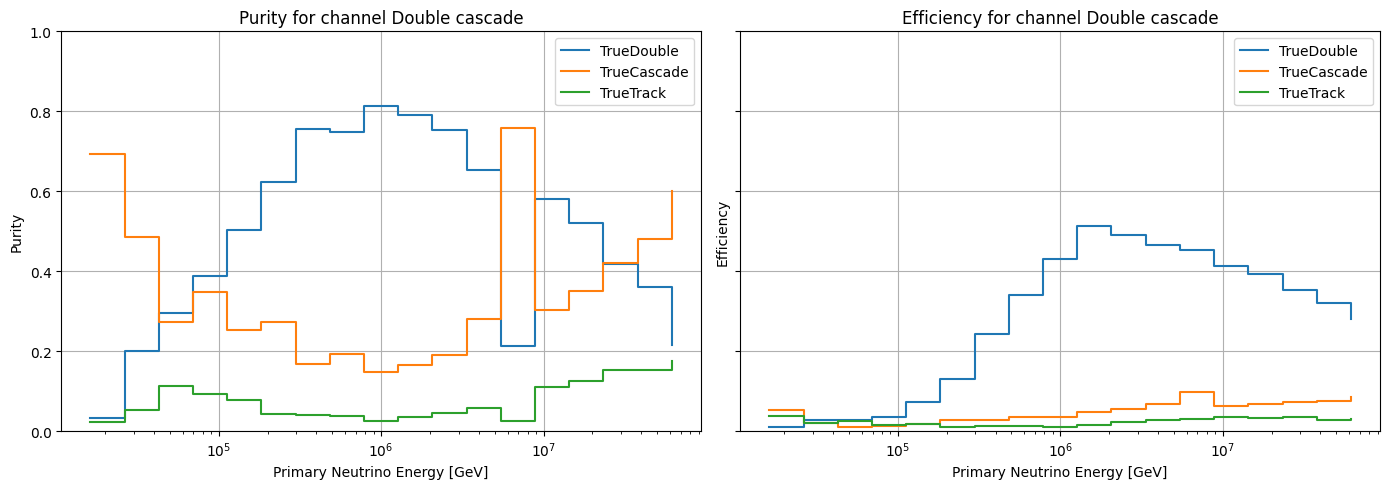

In [82]:
def purity_efficiency_trueclass_plot(simulation_dataset_name, channel, classification_var="FinalTopology", energy_cut_threshold=None):

    simulation_dataset = simulation_datasets[simulation_dataset_name]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    bins = np.geomspace(1e4, 1e8, 20)

    hists = {}
    hists_total = {}

    flavor = "NuAll"

    # Loop over true mc interaction classes
    for MCInteractionEventclass_name,MCInteractionEventclass_int in zip(['TrueCascade', 'TrueDouble', 'TrueTrack'],[1,2,3]):
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
        classification = simulation_dataset[flavor]["weighter"].get_column(classification_var, "value")
        MCInteractionEventclass = simulation_dataset[flavor]["weighter"].get_column("MCInteractionEventclass", "value")
        PrimaryNeutrinoEnergy = simulation_dataset[flavor]["weighter"].get_column("I3MCWeightDict", "PrimaryNeutrinoEnergy")
        RecoETot = simulation_dataset[flavor]["weighter"].get_column("RecoETot", "value")
        
        mask = np.ones_like(RecoETot, dtype=bool)
        mask &= (MCInteractionEventclass == MCInteractionEventclass_int)
        if energy_cut_threshold:
            mask &= RecoETot > energy_cut_threshold
        
        hists_total[MCInteractionEventclass_name], _ = np.histogram(PrimaryNeutrinoEnergy[mask], weights=weights[mask], bins=bins)
        hists[MCInteractionEventclass_name], _ = np.histogram(PrimaryNeutrinoEnergy[mask & (classification == channel)], weights=weights[mask & (classification == channel)], bins=bins)

    # Conventional + Prompt (NuAll)
    flavor_all = "NuAll"
    classification = simulation_dataset[flavor_all]["weighter"].get_column(classification_var, "value")
    ConventionalAtmosphericPassingFractions = simulation_dataset[flavor_all]["weighter"].get_column("ConventionalAtmosphericPassingFractions", "value")
    PromptAtmosphericPassingFractions = simulation_dataset[flavor_all]["weighter"].get_column("PromptAtmosphericPassingFractions", "value")
    RecoETot = simulation_dataset[flavor_all]["weighter"].get_column("RecoETot", "value")
    PrimaryNeutrinoEnergy = simulation_dataset[flavor_all]["weighter"].get_column("I3MCWeightDict", "PrimaryNeutrinoEnergy")

    mask = np.ones_like(RecoETot, dtype=bool)
    if energy_cut_threshold:
        mask &= RecoETot > energy_cut_threshold

    weights_conv = simulation_dataset[flavor_all]["weighter"].get_weights(generator_conv) * livetime_s * ConventionalAtmosphericPassingFractions
    weights_prompt = simulation_dataset[flavor_all]["weighter"].get_weights(generator_pr) * livetime_s * PromptAtmosphericPassingFractions

    hists_total["conv"], _ = np.histogram(PrimaryNeutrinoEnergy[mask], weights=weights_conv[mask], bins=bins)
    hists_total["prompt"], _ = np.histogram(PrimaryNeutrinoEnergy[mask], weights=weights_prompt[mask], bins=bins)

    hists["conv"], _ = np.histogram(PrimaryNeutrinoEnergy[mask & (classification == channel)], weights=weights_conv[mask & (classification == channel)], bins=bins)
    hists["prompt"], _ = np.histogram(PrimaryNeutrinoEnergy[mask & (classification == channel)], weights=weights_prompt[mask & (classification == channel)], bins=bins)

    # total histograms for denominator
    hists_total["total"] = sum(hists_total.values())
    hists["total"] = sum(hists.values())

    # Calculate purity and efficiency
    purity = {comp: hists[comp] / hists["total"] for comp in hists if comp != "total"}
    efficiency = {comp: hists[comp] / hists_total[comp] for comp in hists if comp != "total"}

    # Purity plot
    for MCInteractionEventclass_name in MCInteractionEventclass_names:
        ax1.step(bins[:-1], purity[MCInteractionEventclass_name], where='post', label=MCInteractionEventclass_name)
    ax1.set_xscale('log')
    ax1.set_ylabel('Purity')
    ax1.set_xlabel('Primary Neutrino Energy [GeV]')
    ax1.set_title(f'Purity for channel {channels[channel]}')
    ax1.legend()
    ax1.set_ylim(0, 1)  # <-- Fix y-axis
    ax1.grid(True)

    # Efficiency plot
    for MCInteractionEventclass_name in MCInteractionEventclass_names:
        ax2.step(bins[:-1], efficiency[MCInteractionEventclass_name], where='post', label=MCInteractionEventclass_name)
    ax2.set_xscale('log')
    ax2.set_ylabel('Efficiency')
    ax2.set_xlabel('Primary Neutrino Energy [GeV]')
    ax2.set_title(f'Efficiency for channel {channels[channel]}')
    ax2.legend()
    ax2.set_ylim(0, 1)  # <-- Fix y-axis
    ax2.grid(True)

    plt.tight_layout()
    # plt.savefig(f"{plotting_path}/purity_efficiency_flavor_{simulation_dataset_name}_classification-{classification_var}_channel-{channel}_energycut-{energy_cut_threshold}.pdf")

    print(20*"-", "channel", channel, "classification_var", classification_var, "energy_cut_threshold",energy_cut_threshold)
    for comp in hists:
        print(comp, sum(hists[comp]))
    print(10*"-")
    for comp in hists:
        print(comp, sum(hists_total[comp]))

    plt.show()

# for simulation_dataset_name in simulation_datasets:
#     for channel in channels:
#         for classification_var in classification_vars:
#             for energy_cut_threshold in [None, 60e3]:
#                 purity_efficiency_trueclass_plot( simulation_dataset_name=simulation_dataset_name, channel=channel, classification_var=classification_var, energy_cut_threshold= energy_cut_threshold )

purity_efficiency_trueclass_plot( "spice_tau_reco", 2, "FinalTopology", None )
# purity_efficiency_trueclass_plot( "spice_tau_reco", 2, "FinalEventClass", 60e3 )


/tmp/ipykernel_18314/4168801302.py:39: RuntimeWarning: invalid value encountered in divide
  purity = {comp: hists[comp] / hists["total"] for comp in hists if comp != "total"}
/tmp/ipykernel_18314/4168801302.py:40: RuntimeWarning: invalid value encountered in divide
  efficiency = {comp: hists[comp] / hists_total[comp] for comp in hists if comp != "total"}


-------------------- channel 2 classification_var FinalTopology energy_cut_threshold 60000.0
TrueCascade 1.1782124926365296
TrueDouble 2.624948918115561
TrueTrack 0.3803489478106054
total 4.183510358562697
----------
TrueCascade 55.70090535653126
TrueDouble 20.740904139836818
TrueTrack 23.228683874114886
total 99.67049337048296


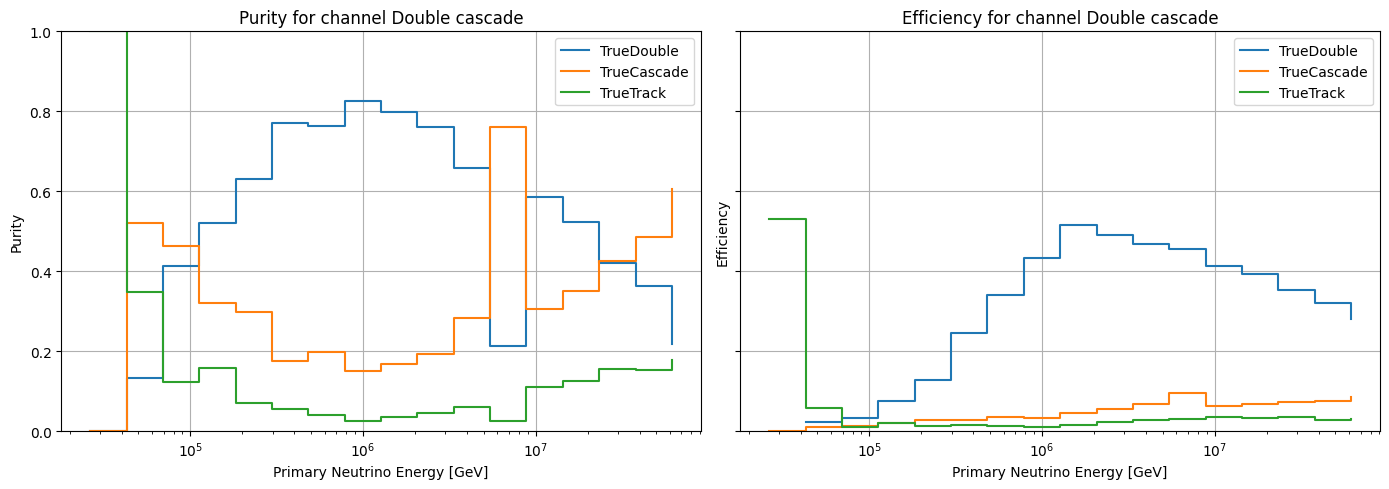

-------------------- channel 2 classification_var FinalEventClass energy_cut_threshold 60000.0
TrueCascade 1.127019844999169
TrueDouble 2.6200557049019233
TrueTrack 0.3795812482656996
total 4.126656798166792
----------
TrueCascade 55.70090535653126
TrueDouble 20.740904139836818
TrueTrack 23.228683874114886
total 99.67049337048296


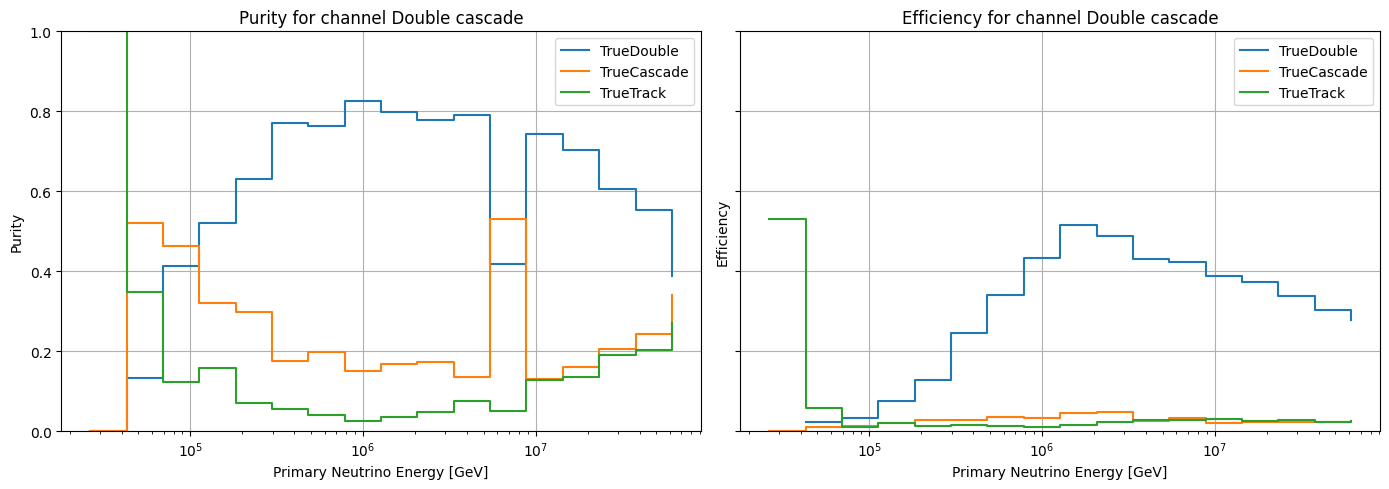

-------------------- channel 2 classification_var FinalTopology energy_cut_threshold 60000.0
TrueCascade 0.4818546717863329
TrueDouble 3.983831960673178
TrueTrack 0.7997332937936289
total 5.2654199262531405
----------
TrueCascade 52.27850562434663
TrueDouble 20.007611490394154
TrueTrack 21.197518555422178
total 93.48363567016295


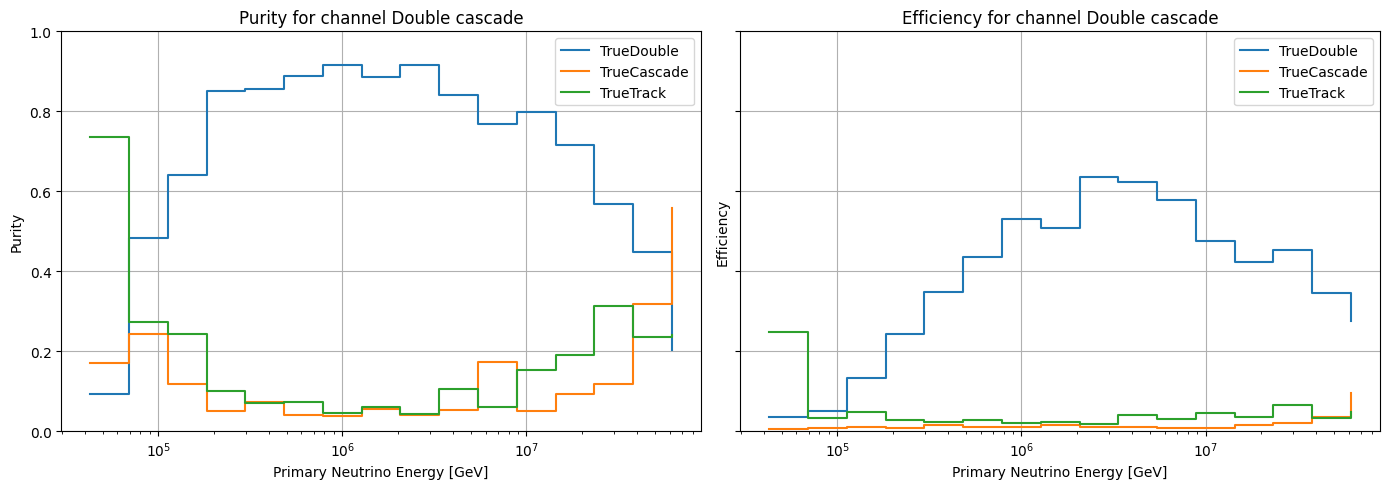

-------------------- channel 2 classification_var FinalEventClass energy_cut_threshold 60000.0
TrueCascade 0.4781392794180517
TrueDouble 3.979781809260194
TrueTrack 0.7990504312199145
total 5.256971519898161
----------
TrueCascade 52.27850562434663
TrueDouble 20.007611490394154
TrueTrack 21.197518555422178
total 93.48363567016295


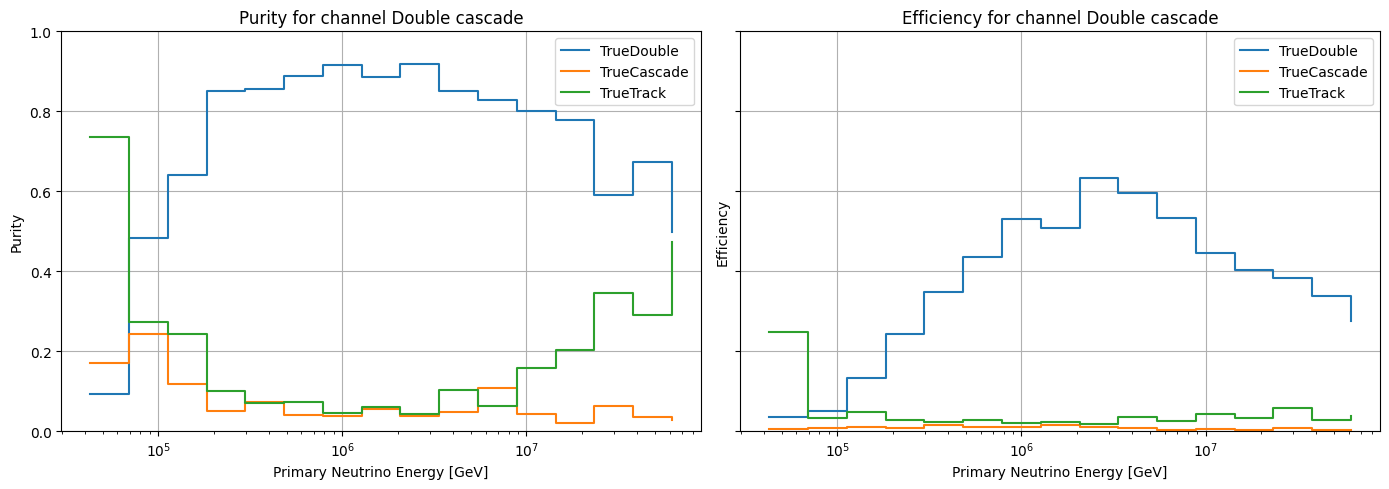

In [ ]:
def purity_efficiency_trueclass_neha_plot(simulation_dataset_name, channel, classification_var="FinalTopology", energy_cut_threshold=None):

    simulation_dataset = simulation_datasets[simulation_dataset_name]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    bins = np.geomspace(1e4, 1e8, 20)

    hists = {}
    hists_total = {}

    flavor = "NuAll"

    # Loop over true mc interaction classes
    for MCInteractionEventclass_name,MCInteractionEventclass_int in zip(['TrueCascade', 'TrueDouble', 'TrueTrack'],[1,2,3]):
        classification = simulation_dataset[flavor]["weighter"].get_column(classification_var, "value")
        MCInteractionEventclass = simulation_dataset[flavor]["weighter"].get_column("MCInteractionEventclass", "value")
        PrimaryNeutrinoEnergy = simulation_dataset[flavor]["weighter"].get_column("I3MCWeightDict", "PrimaryNeutrinoEnergy")
        RecoETot = simulation_dataset[flavor]["weighter"].get_column("RecoETot", "value")

        ConventionalAtmosphericPassingFractions = simulation_dataset[flavor]["weighter"].get_column("ConventionalAtmosphericPassingFractions", "value")
        PromptAtmosphericPassingFractions = simulation_dataset[flavor]["weighter"].get_column("PromptAtmosphericPassingFractions", "value")
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s + \
                  simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s * ConventionalAtmosphericPassingFractions + \
                  simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s * PromptAtmosphericPassingFractions

        mask = np.ones_like(RecoETot, dtype=bool)
        mask &= (MCInteractionEventclass == MCInteractionEventclass_int)
        if energy_cut_threshold:
            mask &= RecoETot > energy_cut_threshold
        
        hists_total[MCInteractionEventclass_name], _ = np.histogram(PrimaryNeutrinoEnergy[mask], weights=weights[mask], bins=bins)
        hists[MCInteractionEventclass_name], _ = np.histogram(PrimaryNeutrinoEnergy[mask & (classification == channel)], weights=weights[mask & (classification == channel)], bins=bins)

    # total histograms for denominator
    hists_total["total"] = sum(hists_total.values())
    hists["total"] = sum(hists.values())

    # Calculate purity and efficiency
    purity = {comp: hists[comp] / hists["total"] for comp in hists if comp != "total"}
    efficiency = {comp: hists[comp] / hists_total[comp] for comp in hists if comp != "total"}

    # Purity plot
    for MCInteractionEventclass_name in MCInteractionEventclass_names:
        ax1.step(bins[:-1], purity[MCInteractionEventclass_name], where='post', label=MCInteractionEventclass_name)
    ax1.set_xscale('log')
    ax1.set_ylabel('Purity')
    ax1.set_xlabel('Primary Neutrino Energy [GeV]')
    ax1.set_title(f'Purity for channel {channels[channel]}')
    ax1.legend()
    ax1.set_ylim(0, 1)  # <-- Fix y-axis
    ax1.grid(True)

    # Efficiency plot
    for MCInteractionEventclass_name in MCInteractionEventclass_names:
        ax2.step(bins[:-1], efficiency[MCInteractionEventclass_name], where='post', label=MCInteractionEventclass_name)
    ax2.set_xscale('log')
    ax2.set_ylabel('Efficiency')
    ax2.set_xlabel('Primary Neutrino Energy [GeV]')
    ax2.set_title(f'Efficiency for channel {channels[channel]}')
    ax2.legend()
    ax2.set_ylim(0, 1)  # <-- Fix y-axis
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f"{plotting_path}/purity_efficiency_flavor_{simulation_dataset_name}_classification-{classification_var}_channel-{channel}_energycut-{energy_cut_threshold}.pdf")

    print(20*"-", "channel", channel, "classification_var", classification_var, "energy_cut_threshold",energy_cut_threshold)
    for comp in hists:
        print(comp, sum(hists[comp]))
    print(10*"-")
    for comp in hists:
        print(comp, sum(hists_total[comp]))

    plt.show()

# for simulation_dataset_name in simulation_datasets:
#     for channel in channels:
#         for classification_var in classification_vars:
#             for energy_cut_threshold in [None, 60e3]:
#                 purity_efficiency_trueclass_plot( simulation_dataset_name=simulation_dataset_name, channel=channel, classification_var=classification_var, energy_cut_threshold= energy_cut_threshold )

# purity_efficiency_trueclass_neha_plot( "spice_tau_reco", 2, "FinalTopology", None )
# purity_efficiency_trueclass_neha_plot( "spice_tau_reco", 2, "FinalEventClass", None )
purity_efficiency_trueclass_neha_plot( "spice_tau_reco", 2, "FinalTopology", 60e3 )
purity_efficiency_trueclass_neha_plot( "spice_tau_reco", 2, "FinalEventClass", 60e3 )

# purity_efficiency_trueclass_neha_plot( "spice_tau_reco", 2, "FinalTopology", None )
# purity_efficiency_trueclass_neha_plot( "spice_tau_reco", 2, "FinalEventClass", None )
purity_efficiency_trueclass_neha_plot( "evtgen_v4_rec_v9", 2, "FinalTopology", 60e3 )
purity_efficiency_trueclass_neha_plot( "evtgen_v4_rec_v9", 2, "FinalEventClass", 60e3 )

